In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 707 kB 4.2 MB/s 
     |████████████████████████████████| 419 kB 55.2 MB/s 
     |████████████████████████████████| 5.9 MB 61.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 376 kB 19.8 MB/s 
     |████████████████████████████████| 5

In [3]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
import torchvision
from torch import nn
from torch.utils.data import Dataset ,DataLoader, random_split
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchvision.utils import make_grid
import math
import torch.nn.functional as F
from torchvision.ops import box_convert
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import random

In [4]:
cfg = {
  "datasets": "/content/drive/MyDrive/Datasets/berat_kurar",

  # base path of the dataset
  "dataset_path": "/content/drive/MyDrive/Datasets/mask-image",
  "image_path": "/content/drive/MyDrive/Datasets/mask-image/original",
  "mask_path": "/content/drive/MyDrive/Datasets/mask-image/labels",

  # define the path of the images and masks dataset that will be used in training
  "train_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/ptrain0",
  "train_mask_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pltrain0",
  "val_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pvalidation0",
  "val_mask_dataset":  "/content/drive/MyDrive/Datasets/berat_kurar/plvalidation0",
  "test_image_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/ptest0",
  "test_mask_dataset": "/content/drive/MyDrive/Datasets/berat_kurar/pltest0",

  # determine the device to be used for training and evaluation
  "device": "cuda" if torch.cuda.is_available() else "cpu",

  # determine if we'll be pinning memory during data loading
  "pin_memory": True if torch.cuda.is_available() else False,

  # define size of the image
  "input_image_height": 224,
	"input_image_width": 224,

  # define the number of classes, input channels
  "num_class": 1,
  "num_channel": 3,

  # define the backbone
  "backbone": "resnet34",

  # define the encoder weights
  "encoder_weight": "imagenet",

  # Initialize the learning rate, number of epochs to train for and the batch size
  "lr": 0.00009,
  "num_epochs": 40,
  "batch_size": 256,

  # define threshold to filter weak predictions
  "threshold": 0.5,

  # define the path that the model checkpoints, prediction will be saved
  "base_output": "/content/drive/MyDrive/output",
  "device": "cuda" if torch.cuda.is_available() else "cpu",
}

In [5]:
class SegmentationDataset(Dataset):
  def __init__(self, img_paths, mask_paths, transforms):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transforms = transforms

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    # load the image from disk, swap its channels from BGR to RGB,
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(self.img_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mask_paths[idx], 0)

    # check to see if we are applying any transformations
    if self.transforms is not None:
      # apply the transformations to both image and its mask
      image = self.transforms(image)
      mask = self.transforms(mask)

    return image, mask


In [7]:
from imutils import paths

train_image_set = sorted(list(paths.list_images(cfg["train_image_dataset"])))
train_mask_set = sorted(list(paths.list_images(cfg["train_mask_dataset"])))
val_image_set = sorted(list(paths.list_images(cfg["val_image_dataset"])))
val_mask_set = sorted(list(paths.list_images(cfg["val_mask_dataset"])))
test_image_set = sorted(list(paths.list_images(cfg["test_image_dataset"])))
test_mask_set = sorted(list(paths.list_images(cfg["test_mask_dataset"])))

print(f"len(train_image_set): {len(train_image_set)}\nlen(train_mask_set): {len(train_mask_set)}:")
print(f"len(val_image_set): {len(val_image_set)}\nlen(val_mask_set): {len(val_mask_set)}:")
print(f"len(test_image_set): {len(test_image_set)}\nlen(test_mask_set): {len(test_mask_set)}:")

len(train_image_set): 50000
len(train_mask_set): 50000:
len(val_image_set): 6000
len(val_mask_set): 6000:
len(test_image_set): 15000
len(test_mask_set): 15000:


In [8]:
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)
IMAGE_RESIZE = (224, 224)

transform = transforms.Compose([
  transforms.ToPILImage(),
 	transforms.Resize((cfg["input_image_height"],cfg["input_image_width"])),
	transforms.ToTensor()
 ])

transform_trainval = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])

In [9]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self, transforms=None):
      super().__init__()
      self.save_hyperparameters()
      self.transform = transforms

    def setup(self, stage=None):
      self.train_dataset = SegmentationDataset(img_paths=train_image_set, mask_paths=train_mask_set, transforms=transform)
      self.val_dataset = SegmentationDataset(img_paths=val_image_set, mask_paths=val_mask_set, transforms=transform)
      self.test_dataset = SegmentationDataset(img_paths=test_image_set, mask_paths=test_mask_set, transforms=transform)

    def train_dataloader(self):
      return DataLoader(self.train_dataset,
                      batch_size=cfg["batch_size"],
                      shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset,
                        batch_size=cfg["batch_size"],
                        shuffle=False)

    def test_dataloader(self):
      return DataLoader(self.test_dataset,
                        batch_size=cfg["batch_size"],
                        shuffle=False)

In [22]:
import segmentation_models_pytorch as smp

class LitModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(
        encoder_name = cfg["backbone"],
        encoder_weights = cfg["encoder_weight"],
        in_channels = cfg["num_channel"],
        classes = cfg["num_class"],
        activation = None
      )
    
  def forward(self, x):
    self.model.eval()
    x = self.model(x)
    return x

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    self.log("val_loss", loss)
    return loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    self.log("test_loss", loss)
    return loss
     
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=cfg["lr"])

In [23]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

dm = LitDataModule(transforms=transform)
dm.setup()
model = LitModel()
trainer = pl.Trainer(max_epochs=cfg["num_epochs"],
                  accelerator="auto",
                  devices=1 if torch.cuda.is_available() else None,
                  callbacks=[LearningRateMonitor(logging_interval="step"),
                                TQDMProgressBar(refresh_rate=10),
                             EarlyStopping(monitor="val_loss", mode="min")],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
trainer.validate(model, dm)

In [ ]:
trainer.test(model, dm)

In [ ]:
# serialize the model to disk
torch.save(model, cfg["base_output"] + "/pyimagesearch_example_lightning_testLoss_0_109.pth")

In [ ]:
def prepare_plot(original_img, pred_mask):
  # initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

  # plot original image, its mask, and the predicted mask
  ax[0].imshow(original_img)
  ax[1].imshow(pred_mask)

  # set the titles of the subplots
  ax[0].set_title("image")
  ax[1].set_title("predicted mask")

  # set the layout of the figure and display it
  figure.tight_layout()
  figure.show()

In [ ]:
def make_predictions(model, image_path):
  # set the model evaluation mode
  model.eval()

  # turn off gradient tracking
  with torch.no_grad():
    # load the image from disk, swap its color channels, cast it to float data
    # type and scale its pixel values
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0

    # resize the image and make a copy of it for visualization
    image = cv2.resize(image, (224, 224))
    orig = image.copy()

    # make the channel axis to be the leading one, add a batch dimension, create a pytorch
    # tensor, and flash it to the current device
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(cfg['device'])

    # make the prediction, pass the results through the sigmoid function
    # and convert the result to a numpy array
    pred_mask = model(image).squeeze()
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask = pred_mask.cpu().numpy()

    # filter out the weak predictions and convert them to integers
    pred_mask = (pred_mask > cfg['threshold'])*255
    pred_mask = pred_mask.astype(np.uint8)

    # prepare a plot for visualization
    prepare_plot(orig, pred_mask)

In [ ]:
test_img_filenames = os.listdir(cfg["test_image_dataset"])
img_paths = [cfg["test_image_dataset"] + "/" + file for file in test_img_filenames]

[INFO] loading up test image paths...
[INFO] load up model...


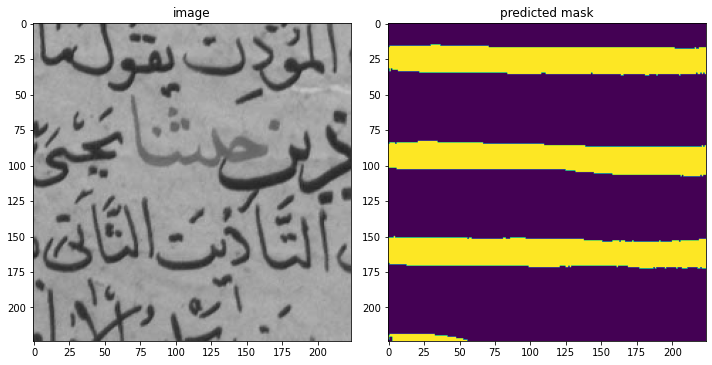

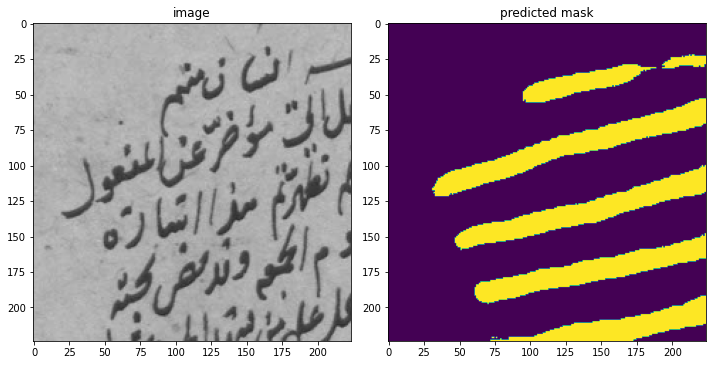

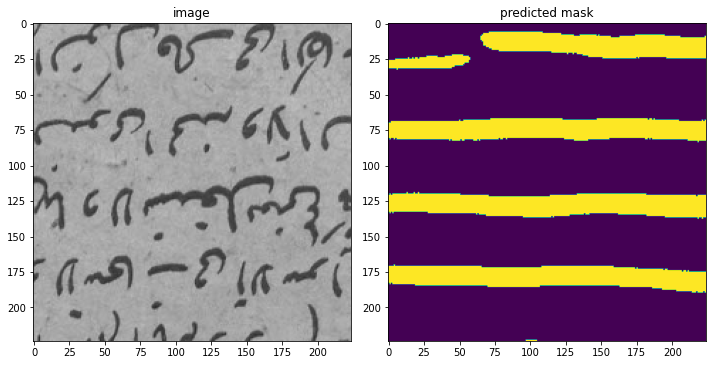

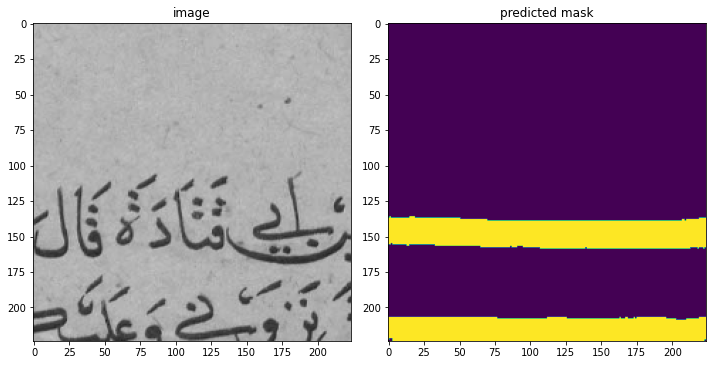

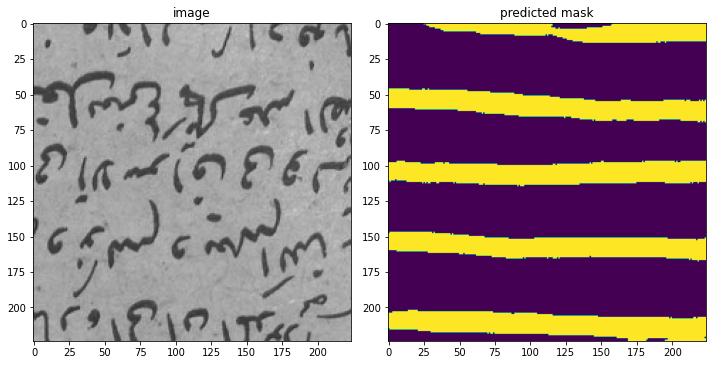

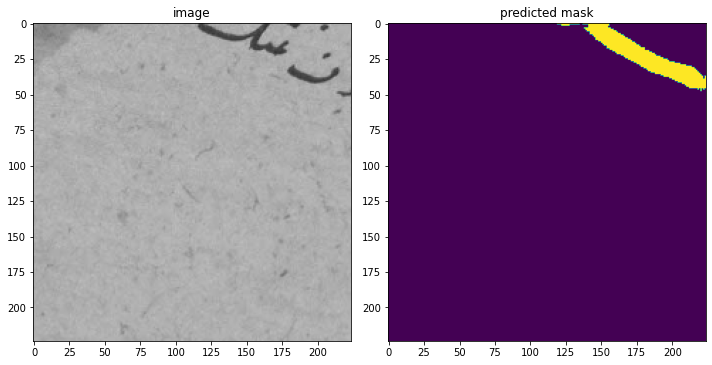

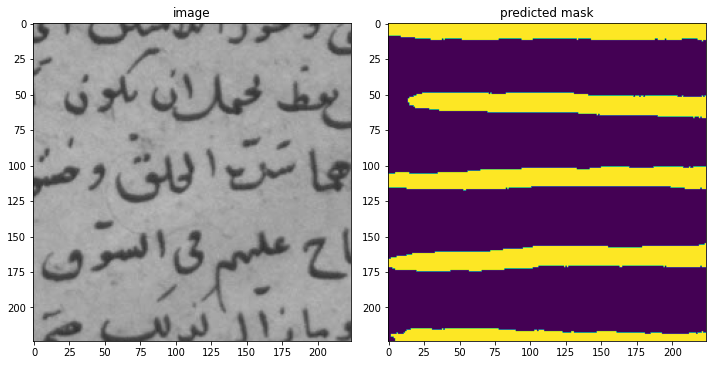

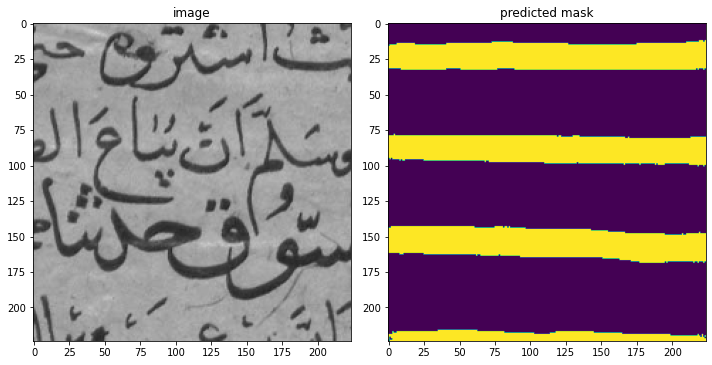

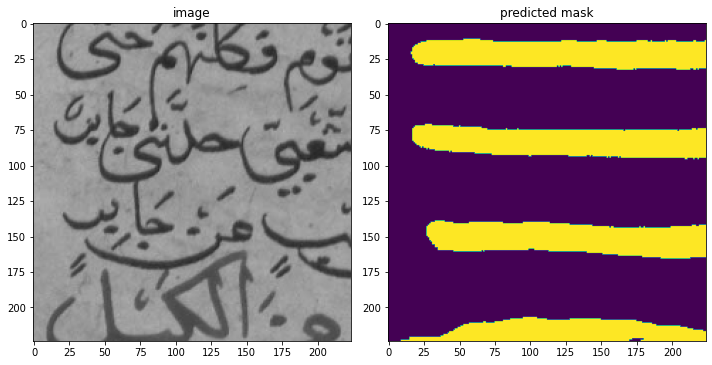

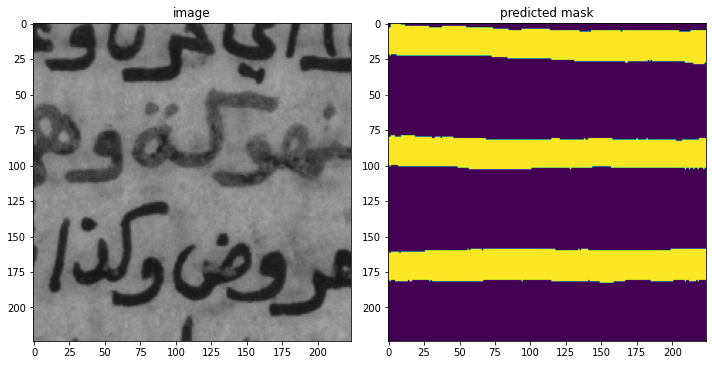

In [ ]:
# load the image paths in out testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
img_paths = np.random.choice(img_paths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load(cfg["base_output"] + "/pyimagesearch_example_lightning_testLoss0_25.pth").to(cfg["device"])

# iterate over the randomly selected test image paths
for path in img_paths:
  # make predictions and visualize the results
  make_predictions(model, path)

In [ ]:
high_resolution_test_img_files = os.listdir("/content/drive/MyDrive/Datasets/mask-image/original")
high_resolution_test_img_files_paths = ["/content/drive/MyDrive/Datasets/mask-image/original/" + file for file in high_resolution_test_img_files]


In [ ]:
high_resolution_test_img_files

['1.png',
 '7.png',
 '9.png',
 '26.png',
 '15.png',
 '21.png',
 '23.png',
 '2.png',
 '5.png',
 '10.png',
 '13.png',
 '18.png',
 '4.png',
 '0.png',
 '3.png',
 '6.png',
 '8.png',
 '11.png',
 '12.png',
 '14.png',
 '16.png',
 '19.png',
 '20.png',
 '22.png',
 '24.png',
 '25.png',
 '27.png',
 '28.png',
 '29.png',
 '17.png']

In [ ]:
high_resolution_test_img_files_paths

['/content/drive/MyDrive/Datasets/mask-image/original/1.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/7.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/9.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/26.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/15.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/21.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/23.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/2.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/5.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/10.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/13.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/18.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/4.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/0.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/3.png',
 '/content/drive/MyDrive/Datasets/mask-image/original/6.png',
 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


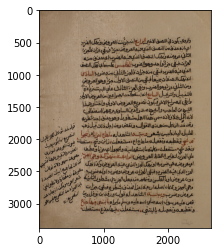

In [ ]:
image = cv2.imread(high_resolution_test_img_files_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/Datasets/mask-image/original/0.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/Datasets/mask-image/original/0.png')
image.show()

In [ ]:
%matplotlib inline
from IPython.display import Image
Image('/content/drive/MyDrive/Datasets/mask-image/original/0.png')

Output hidden; open in https://colab.research.google.com to view.

[INFO] loading up test image paths...
[INFO] load up model...


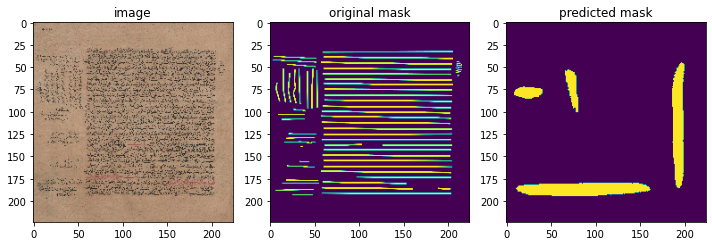

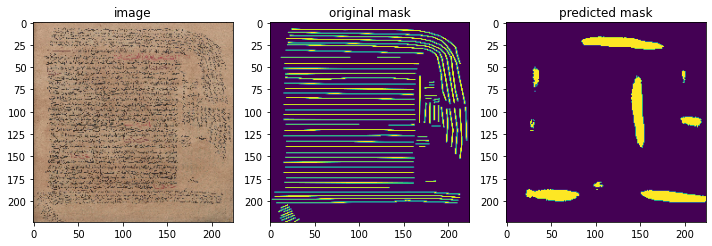

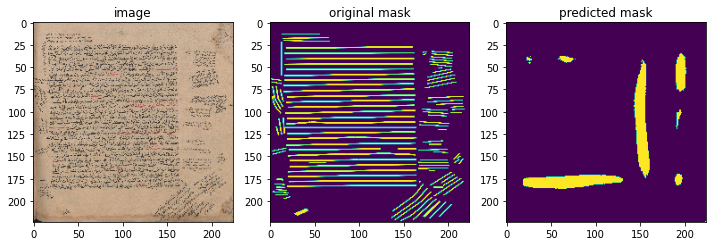

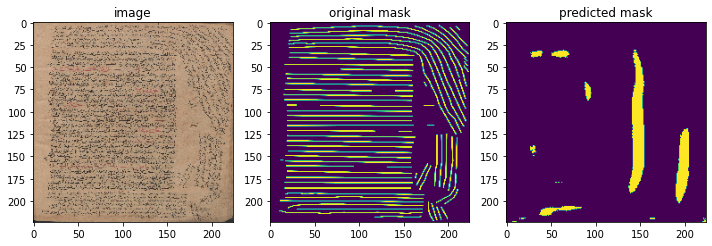

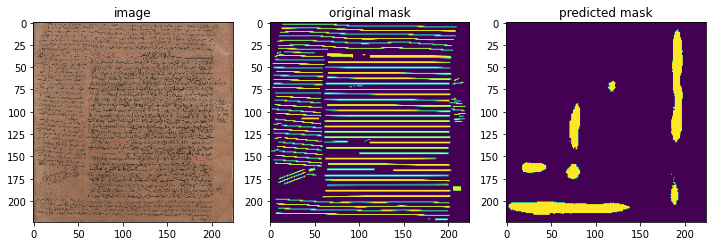

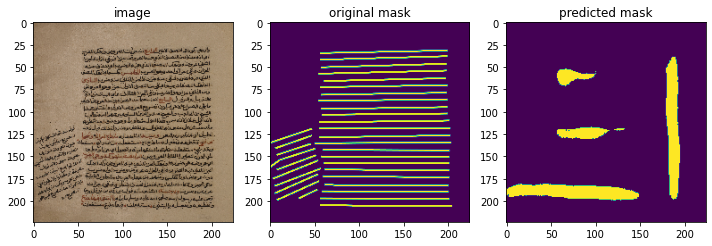

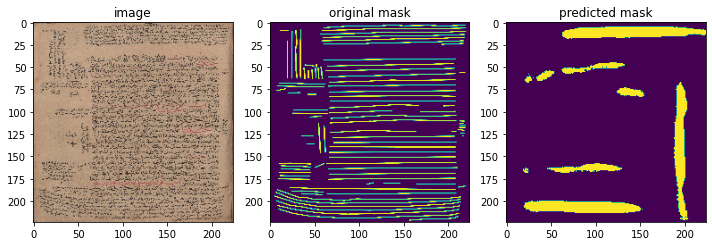

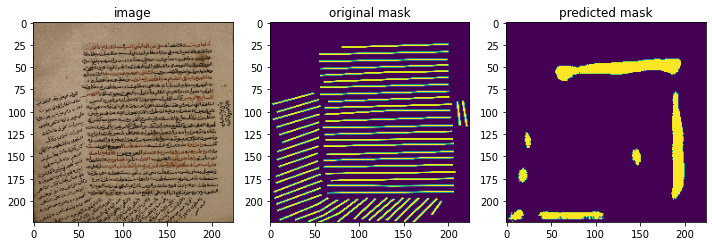

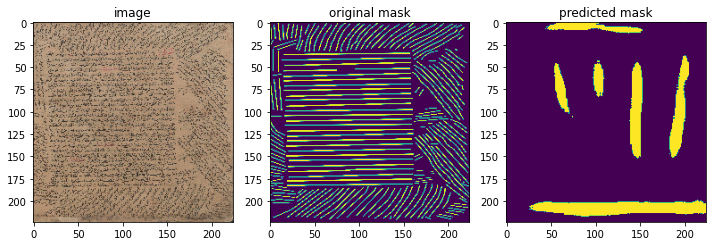

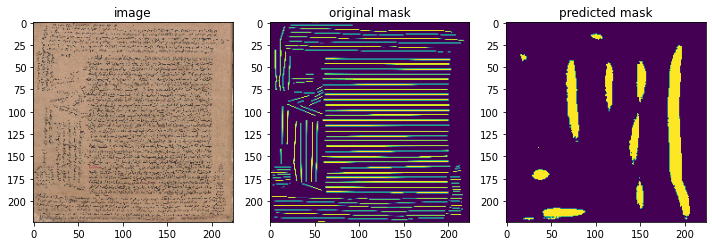

In [ ]:
# load the image paths in out testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
high_resolution_test_img_files_paths = np.random.choice(high_resolution_test_img_files_paths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load(cfg["base_output"] + "/pyimagesearch_example_lightning_testLoss0_25.pth").to(cfg["device"])

# iterate over the randomly selected test image paths
for path in high_resolution_test_img_files_paths:
  # make predictions and visualize the results
  make_predictions(model, path)